In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import pandas_datareader as pdr
import yfinance as yf
from helper_functions import *
import talib as ta
from talib import MA_Type
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.tsa.stattools import adfuller

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

## Process:

* Get data and save as csv
* Load data then process with it
* Create the list for data_for then loop to create the data for each one
* Save the data above
* Load the data and put everthing together
* check if any number is good for other lable 
    * Example: Create the data for Closep but somehow the number is good corraration to Highp and etc
* Pick all the non-stationary data by checking p-value


In [55]:
symbols = {"SoftBank": "9984.T", "Rakuten": "4755.T", "Ajinomoto": "2802.T", "TOYOTA": "7203.T"}
data_length = 30

sb = get_data(symbols["Rakuten"], data_length)

[*********************100%***********************]  1 of 1 completed


In [56]:
sb.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-04-19,398.0,644.0,360.0,600.0,571.375549,4000000
2000-04-20,610.0,808.0,606.0,800.0,761.834045,3000000
2000-04-21,792.0,980.0,790.0,860.0,818.971497,2000000
2000-04-24,870.0,910.0,790.0,790.0,752.311157,1000000
2000-04-25,790.0,866.0,700.0,850.0,809.448669,1000000


## Add Indicator

In [5]:
def preprocess_data(df, data_for, SMA=True, sma5=5, sma10=10, sma20=20,
              MACD=True, short_span=8, long_span=17, macd_span=9, 
              RSI=True, timeperiod=14, SOI=True, slowk_period=3, fastk_period=14, 
              Bband=True):
    """
    data_for: pick one of them ["Adj Close", "Open", "high", "Low"]
    """
    # Fill the zero value on open price to previous closing price
    for i, open_price in enumerate(df["Open"]):
        if open_price == 0.0:
            df["Open"].iloc[i] = df["Adj Close"].iloc[i-1]
            
    df["DiffClose$"] = df["Adj Close"].diff()
    df["DiffOpen$"] = df["Open"].diff()
    df["DiffHigh$"] = df["High"].diff()
    df["DiffLow$"] = df["Low"].diff()
          
    closeps = []
    openps = []
    highs = []
    lows = []
    for i in range(len(df)):
        closep = df["DiffClose$"].iloc[i] / df["Adj Close"].iloc[i-1]
        closeps.append(closep)
        
    for i in range(len(df)):
        openp = df["DiffOpen$"].iloc[i] / df["Open"].iloc[i-1]
        openps.append(openp)
        
    for i in range(len(df)):
        highp = df["DiffHigh$"].iloc[i] / df["High"].iloc[i-1]
        highs.append(highp)
        
    for i in range(len(df)):
        lowp = df["DiffLow$"].iloc[i] / df["Low"].iloc[i-1]
        lows.append(lowp)
        
    df["Closep"] = closeps
    df["Openp"] = openps
    df["Highp"] = highs
    df["Lowp"] = lows
    
    if data_for == "Adj Close":
        percent = "Closep"
    elif data_for == "Open":
        percent = "Openp"
    elif data_for == "High":
        percent = "Highp"
    else:
        percent = "Lowp"
    
    # SMA
    if SMA:
        df["SMA5"] = df[data_for].rolling(sma5).mean()
        df["SMA10"] = df[data_for].rolling(sma10).mean()
        df["SMA20"] = df[data_for].rolling(sma20).mean()
        
        df["smap5"] = df[percent].rolling(sma5).mean()
        df["smap10"] = df[percent].rolling(sma10).mean()
        df["smap20"] = df[percent].rolling(sma20).mean()
        
        
    # MACD
    if MACD:
        # Calculate the short term exponential moving average
        shortEMA = df[data_for].ewm(span=short_span, adjust=False).mean()
        # Calculate the long term exponential moving average
        longEMA = df[data_for].ewm(span=long_span, adjust=False).mean()
        # Calculate MACD line
        MACD = shortEMA - longEMA
        # calculate the signal line
        signal = MACD.ewm(span=macd_span, adjust=False).mean()
        # Add to the DataFrame
        df["MACD"] = MACD
        df["Signal Line"] = signal
        
        # Calculate the short term exponential moving average with stationary data
        shortEMA = df[percent].ewm(span=short_span, adjust=False).mean()
        # Calculate the long term exponential moving average
        longEMA = df[percent].ewm(span=long_span, adjust=False).mean()
        # Calculate MACD line
        MACD = shortEMA - longEMA
        # calculate the signal line
        signal = MACD.ewm(span=macd_span, adjust=False).mean()
        # Add to the DataFrame
        df["macdp"] = MACD
        df["signal_linep"] = signal
        
    # RSI
    if RSI:
        df["RSI"] = ta.RSI(df[data_for], timeperiod=timeperiod)
        
        df["rsip"] = ta.RSI(df[percent], timeperiod=timeperiod)
        
    # Stochastic
    if SOI:
        df["SlowK"], df["SlowD"] = ta.STOCH(high=df["High"],
                                   low=df["Low"],
                                   close=df["Adj Close"], 
                                   slowk_period=slowk_period,
                                   fastk_period=fastk_period)
        
        df["slowKp"], df["slowDp"] = ta.STOCH(high=df["Highp"],
                                   low=df["Lowp"],
                                   close=df["Closep"], 
                                   slowk_period=slowk_period,
                                   fastk_period=fastk_period)
        
    # Bollinger Band
    if Bband:
        df["Bband_upper"], df["Bband_mid"], df["Bband_lower"] = ta.BBANDS(df[data_for], matype=MA_Type.T3)
        
        df["BBuperp"], df["BBmidp"], df["BBlowp"] = ta.BBANDS(df[percent], matype=MA_Type.T3)
        
    df.dropna(inplace=True)
        
    return df

In [9]:
symbol = "AMD"
date = "2022-04-16"
#date = dt.date.today().strftime("%Y-%m-%d") 

In [176]:
data = get_data(symbol, 50) 
data.to_csv(f"{symbol}-{date}")

[*********************100%***********************]  1 of 1 completed


In [6]:
data_for_pred = ["Open", "Close", "High", "Low"]

In [186]:
for d in data_for_pred:
    base_df = pd.read_csv(f"{symbol}-{date}", index_col="Date")
    df = preprocess_data(base_df, d)
    df.to_csv(f"{symbol}-{date}-{d}")

C:\Users\Owner\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Owner\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Owner\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

In [10]:
open_df = pd.read_csv(f"{symbol}-{date}-{data_for_pred[0]}", index_col="Date")
close_df = pd.read_csv(f"{symbol}-{date}-{data_for_pred[1]}", index_col="Date")
high_df = pd.read_csv(f"{symbol}-{date}-{data_for_pred[2]}", index_col="Date")
low_df = pd.read_csv(f"{symbol}-{date}-{data_for_pred[3]}", index_col="Date")

In [11]:
open_df.shape, close_df.shape, high_df.shape, low_df.shape

((10587, 36), (10587, 36), (10587, 36), (10587, 36))

In [12]:
dfs = [open_df, close_df, high_df, low_df]

In [13]:
close_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'DiffClose$',
       'DiffOpen$', 'DiffHigh$', 'DiffLow$', 'Closep', 'Openp', 'Highp',
       'Lowp', 'SMA5', 'SMA10', 'SMA20', 'smap5', 'smap10', 'smap20', 'MACD',
       'Signal Line', 'macdp', 'signal_linep', 'RSI', 'rsip', 'SlowK', 'SlowD',
       'slowKp', 'slowDp', 'Bband_upper', 'Bband_mid', 'Bband_lower',
       'BBuperp', 'BBmidp', 'BBlowp'],
      dtype='object')

In [14]:
close_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10587 entries, 1980-04-22 to 2022-04-14
Data columns (total 36 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          10587 non-null  float64
 1   High          10587 non-null  float64
 2   Low           10587 non-null  float64
 3   Close         10587 non-null  float64
 4   Adj Close     10587 non-null  float64
 5   Volume        10587 non-null  int64  
 6   DiffClose$    10587 non-null  float64
 7   DiffOpen$     10587 non-null  float64
 8   DiffHigh$     10587 non-null  float64
 9   DiffLow$      10587 non-null  float64
 10  Closep        10587 non-null  float64
 11  Openp         10587 non-null  float64
 12  Highp         10587 non-null  float64
 13  Lowp          10587 non-null  float64
 14  SMA5          10587 non-null  float64
 15  SMA10         10587 non-null  float64
 16  SMA20         10587 non-null  float64
 17  smap5         10587 non-null  float64
 18  smap10        105

In [211]:
close_df.describe()

,Open,High,Low,Close,Adj Close,Volume,DiffClose$,DiffOpen$,DiffHigh$,DiffLow$,...,SlowK,SlowD,slowKp,slowDp,Bband_upper,Bband_mid,Bband_lower,BBuperp,BBmidp,BBlowp
count,10587.000000,10587.000000,10587.000000,10587.000000,10587.000000,1.058700e+04,10587.000000,10587.000000,10587.000000,10587.000000,...,1.058700e+04,10587.000000,10587.000000,10587.000000,10587.000000,10587.000000,10587.000000,10587.000000,10587.000000,10587.000000
mean,15.183216,15.501545,14.838810,15.171401,15.171401,1.678173e+07,0.008574,0.009072,0.009070,0.008561,...,5.066703e+01,50.668229,49.722595,49.720122,15.970137,15.156571,14.343006,0.053740,0.000995,-0.051749
std,20.059245,20.463613,19.606825,20.039762,20.039762,2.625245e+07,0.862483,0.895336,0.770832,0.754891,...,2.866256e+01,27.862818,21.285819,18.849796,21.050644,20.013060,19.003802,0.037166,0.015787,0.038936
min,1.620000,1.690000,1.610000,1.620000,1.620000,0.000000e+00,-12.589996,-12.840004,-11.070007,-12.800003,...,-1.657933e-14,1.639748,-20.596206,-3.238976,1.736993,1.684728,1.455815,-0.015204,-0.116765,-0.534140
25%,5.187500,5.312500,5.062500,5.187500,5.187500,1.194400e+06,-0.170000,-0.187500,-0.150001,-0.145833,...,2.351589e+01,24.500632,33.937361,35.595727,5.535933,5.174319,4.849857,0.029666,-0.008012,-0.066341
50%,9.531250,9.750000,9.312500,9.500000,9.500000,6.341600e+06,0.000000,0.000000,0.000000,0.000000,...,5.182799e+01,52.023554,49.523206,49.633004,10.033287,9.523795,8.993316,0.045402,0.000813,-0.043526
75%,15.556250,15.850000,15.250000,15.500000,15.500000,2.071175e+07,0.180000,0.187500,0.160000,0.169999,...,7.715601e+01,76.430700,65.592218,63.421461,16.243510,15.479138,14.736644,0.068377,0.010052,-0.027406
max,163.279999,164.460007,156.100006,161.910004,161.910004,3.250584e+08,13.820007,16.309998,12.799995,11.779999,...,1.000000e+02,98.245614,118.168525,100.108779,166.856348,157.338668,150.855171,0.539984,0.086053,0.011761


Biggest increase from previous day: 2016-04-22
Change in %: 52.29
Biggest decrease from prvious day: 1992-06-18
Change in %: -37.93


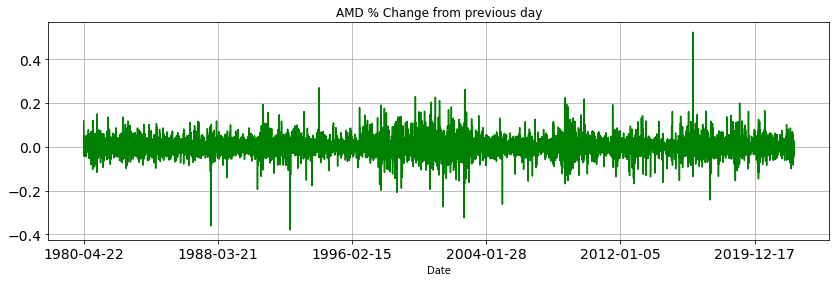

In [212]:
close_df["Closep"].plot(color="g", title=symbol + " " + "% Change from previous day", fontsize=14, figsize=(14, 4)).grid()
print("Biggest increase from previous day: " + str(close_df["Closep"].idxmax()))
print("Change in %: " + str(np.round(close_df["Closep"].max() * 100, 2)))
print("Biggest decrease from prvious day: " + str(close_df["Closep"].idxmin()))
print("Change in %: " + str(np.round(close_df["Closep"].min() * 100, 2)))

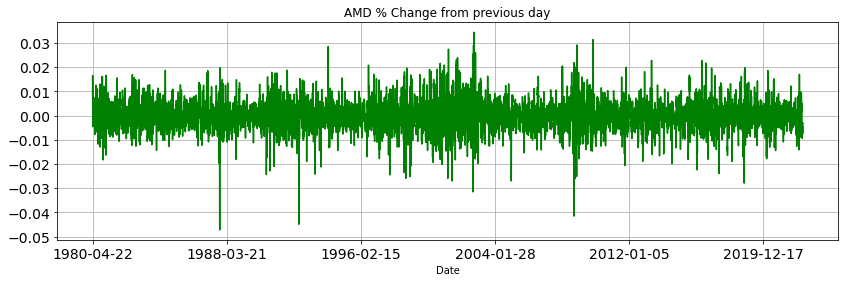

In [213]:
close_df["macdp"].plot(color="g", title=symbol + " " + "% Change from previous day", fontsize=14, figsize=(14, 4)).grid()

In [221]:
%%time
# Find out the which column is the non-stationary data
cols = list(close_df.columns)
data_name = ["OPEN", "CLOSE", "HIGH", "LOW"]
for i in range(len(dfs)):
    df = dfs[i]
    print(f"DATA: {data_name[i]}\n")
    for col in cols:
        try:
            print(col, ":", adfuller(df[col])[1])
        except:
            print(col)

DATA: OPEN
Open : 0.809116137136317
High : 0.7093250520117386
Low : 0.8058242292180195
Close : 0.6919219008149451
Adj Close : 0.6919219008149451
Volume : 0.022783713358109803
DiffClose$ : 3.6952805979426216e-27
DiffOpen$
DiffHigh$ : 6.495755437929189e-28
DiffLow$ : 9.245793193740417e-28
Closep : 0.0
Openp : 0.0
Highp : 0.0
Lowp : 0.0
SMA5 : 0.9651660190036044
SMA10 : 0.9825820186414248
SMA20 : 0.9945161149916171
smap5 : 2.6900519206300774e-28
smap10 : 1.5176478594107547e-28
smap20 : 3.2587065085813925e-28
MACD : 1.4678362636301696e-24
Signal Line : 4.300077054072223e-20
macdp : 0.0
signal_linep : 0.0
RSI : 8.143922037992632e-30
rsip : 0.0
SlowK : 1.726160123113581e-24
SlowD : 1.151067271562553e-24
slowKp : 1.1518476201020481e-28
slowDp : 7.72013398915e-28
Bband_upper : 0.9075118171914445
Bband_mid : 0.9756860808548116
Bband_lower : 0.9702237358923154
BBuperp : 1.62237048480566e-20
BBmidp : 0.0
BBlowp : 2.12513311166896e-21
DATA: CLOSE
Open : 0.809116137136317
High : 0.7093250520117386


### Look at those correrations, I create the indicator based on Closing price so good corretaion with the numbers based on the closing price but not for other prices such as Open, Hig, and Lows. 

#### I must make indications based on all the numbers to predict each number. 

#### Question:

Should I make class? and how can I do and what is the benefit to do so? 

In [222]:
# Correlation coefficient matrix
corr_open = open_df.corr()
corr_close = close_df.corr()
corr_high = high_df.corr()
corr_low = low_df.corr()
corr_dfs = [corr_open, corr_close, corr_high, corr_low]

In [225]:
close_corr = corr_close[["Closep", "DiffClose$"]].sort_values("Closep", ascending=False)
close_corr

,Closep,DiffClose$
Closep,1.000000,0.611753
Highp,0.708318,0.420021
Lowp,0.662429,0.400546
DiffClose$,0.611753,1.000000
rsip,0.610636,0.391961
macdp,0.454519,0.272946
DiffHigh$,0.438316,0.686594
DiffLow$,0.423398,0.658894
slowKp,0.375953,0.240585
RSI,0.338102,0.213971


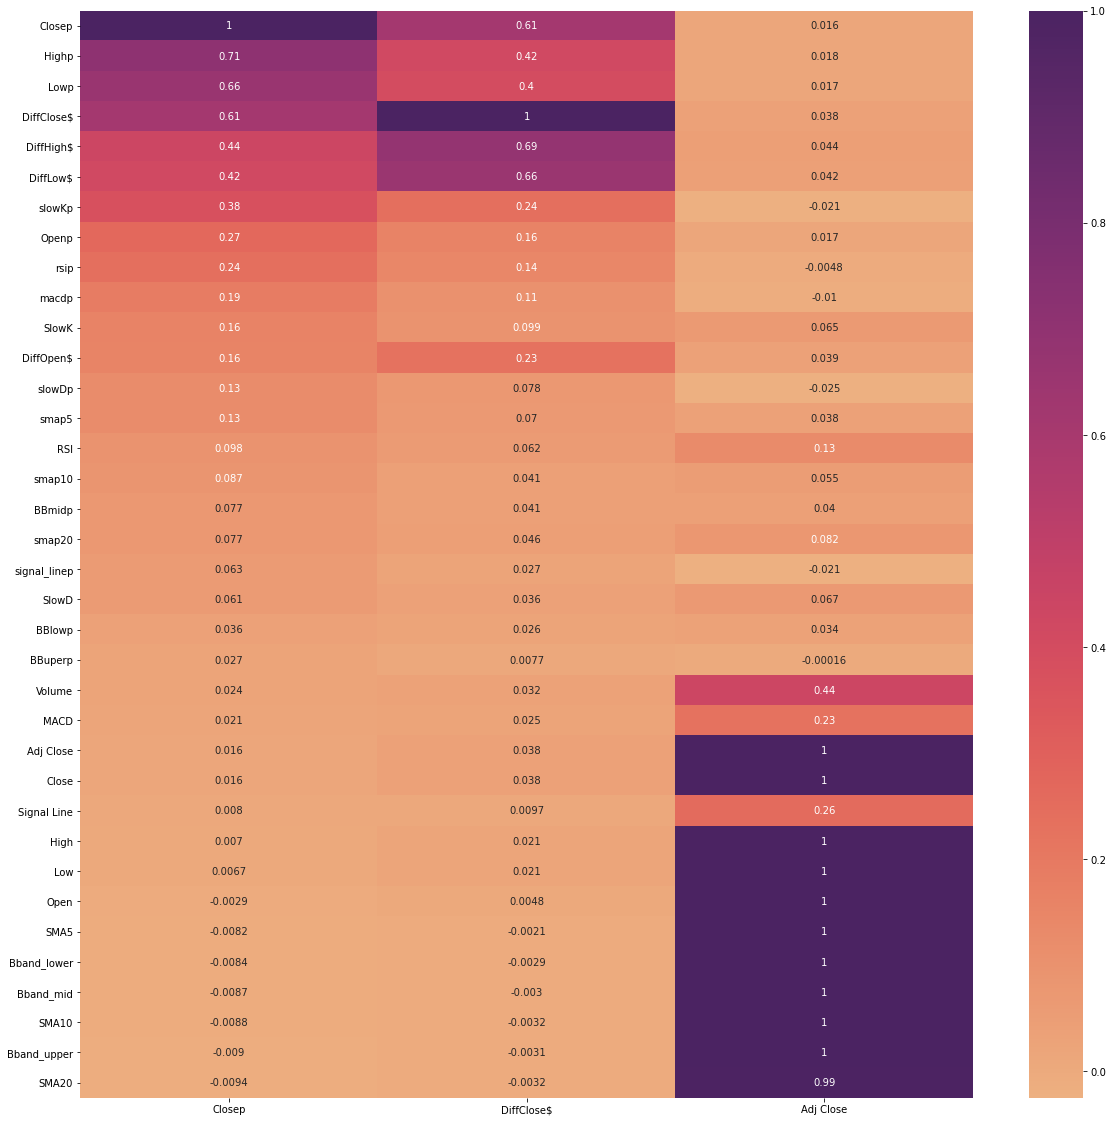

In [88]:
plt.figure(figsize=(20, 20))
heatmap = sns.heatmap(close_corr, annot=True, cmap="flare")

In [89]:
open_corr = corr[["Openp", "DiffOpen$", "Open"]].sort_values("Openp", ascending=False)
open_corr

,Openp,DiffOpen$,Open
Openp,1.000000,0.611516,0.017666
rsip,0.907790,0.560056,-0.004275
macdp,0.703862,0.421968,-0.009404
Lowp,0.687429,0.413135,0.006869
Highp,0.645803,0.392317,0.007198
DiffOpen$,0.611516,1.000000,0.040084
smap5,0.450432,0.268123,0.038122
DiffLow$,0.444930,0.694732,0.024592
DiffHigh$,0.418179,0.675844,0.026556
slowKp,0.337434,0.215604,-0.028839


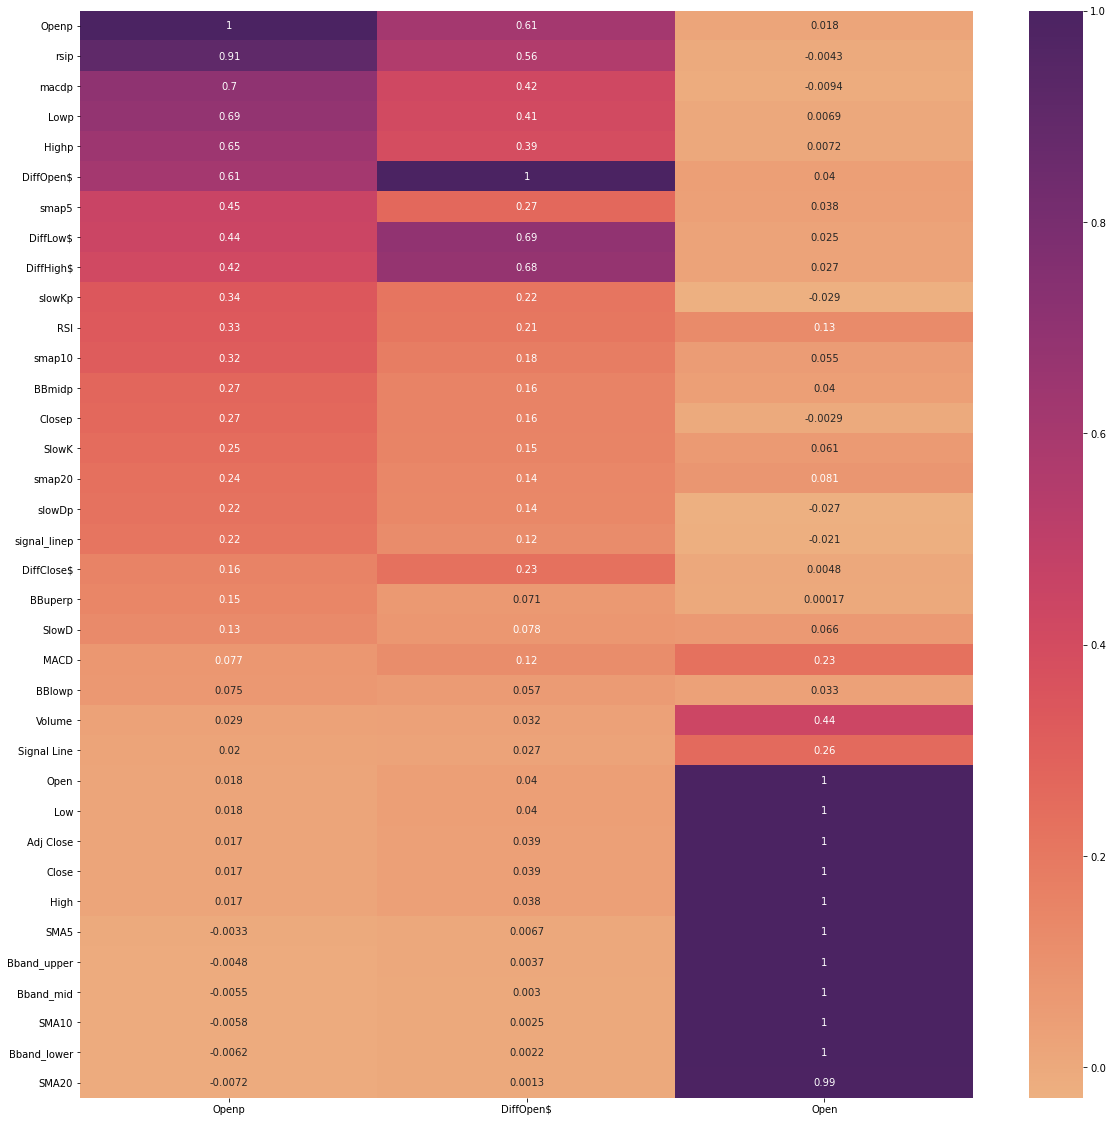

In [90]:
plt.figure(figsize=(20, 20))
heatmap = sns.heatmap(open_corr, annot=True, cmap="flare")

In [91]:
high_corr = corr[["Highp", "DiffHigh$", "High"]].sort_values("Highp", ascending=False)
high_corr

,Highp,DiffHigh$,High
Highp,1.000000,0.610842,0.015377
Closep,0.708318,0.438316,0.006955
Lowp,0.657635,0.425826,0.010996
Openp,0.645803,0.418179,0.016817
DiffHigh$,0.610842,1.000000,0.038892
rsip,0.590900,0.386157,-0.004853
macdp,0.457032,0.292543,-0.009833
DiffLow$,0.428861,0.718946,0.031126
DiffClose$,0.420021,0.686594,0.020610
slowKp,0.394453,0.266612,-0.024922


In [166]:
sum(high_corr["Highp"].values)

8.349165010596042

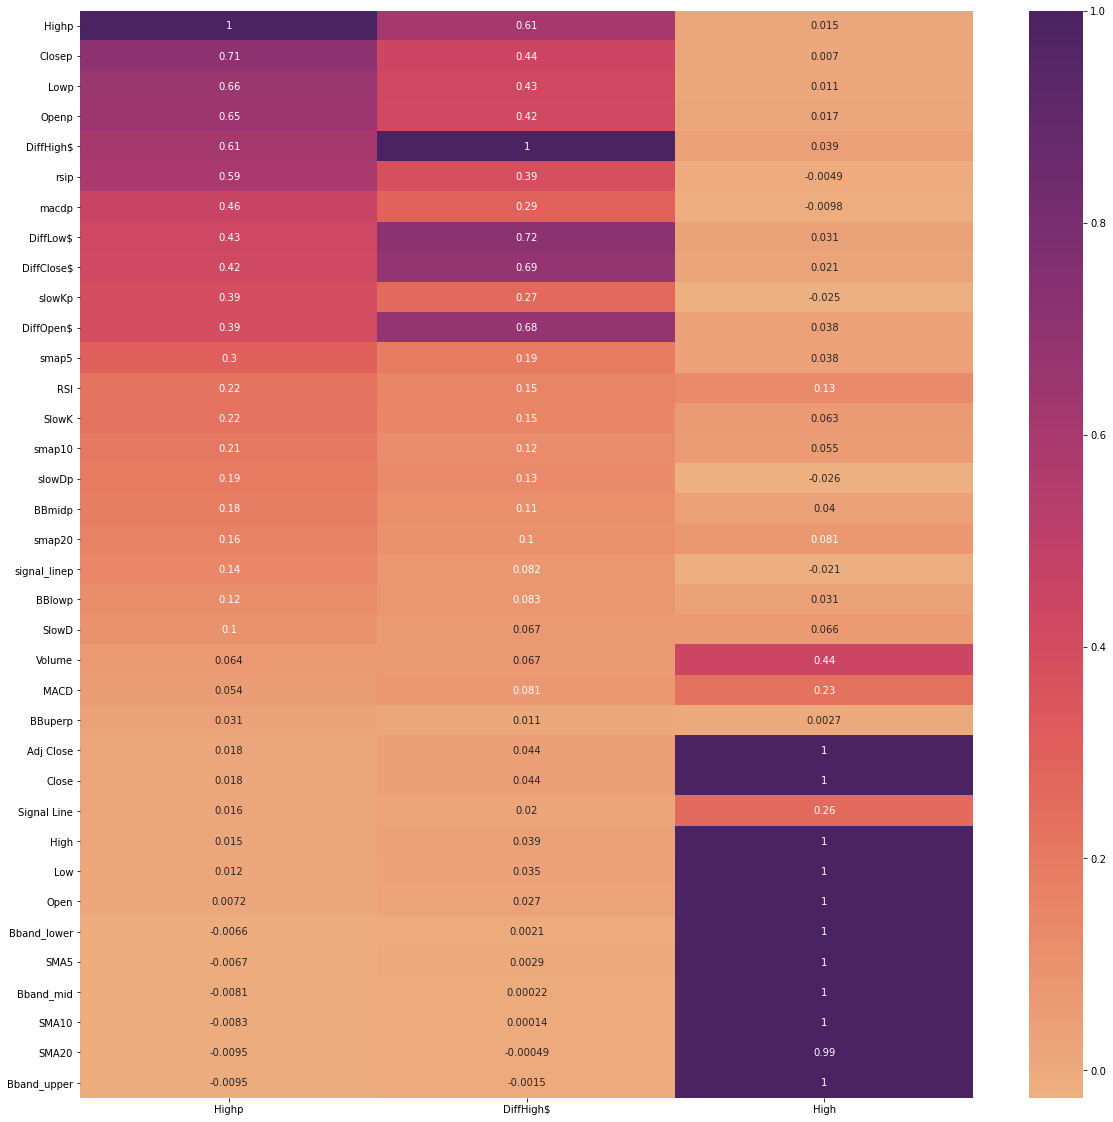

In [92]:
plt.figure(figsize=(20, 20))
heatmap = sns.heatmap(high_corr, annot=True, cmap="flare")

In [93]:
low_corr = corr[["Lowp", "DiffLow$", "Low"]].sort_values("Lowp", ascending=False)
low_corr

,Lowp,DiffLow$,Low
Lowp,1.000000,0.618561,0.014940
Openp,0.687429,0.444930,0.017582
Closep,0.662429,0.423398,0.006680
Highp,0.657635,0.428861,0.012256
rsip,0.623215,0.409988,-0.004126
DiffLow$,0.618561,1.000000,0.038205
macdp,0.476910,0.303766,-0.009259
DiffHigh$,0.425826,0.718946,0.035292
DiffOpen$,0.413135,0.694732,0.039623
DiffClose$,0.400546,0.658894,0.021105


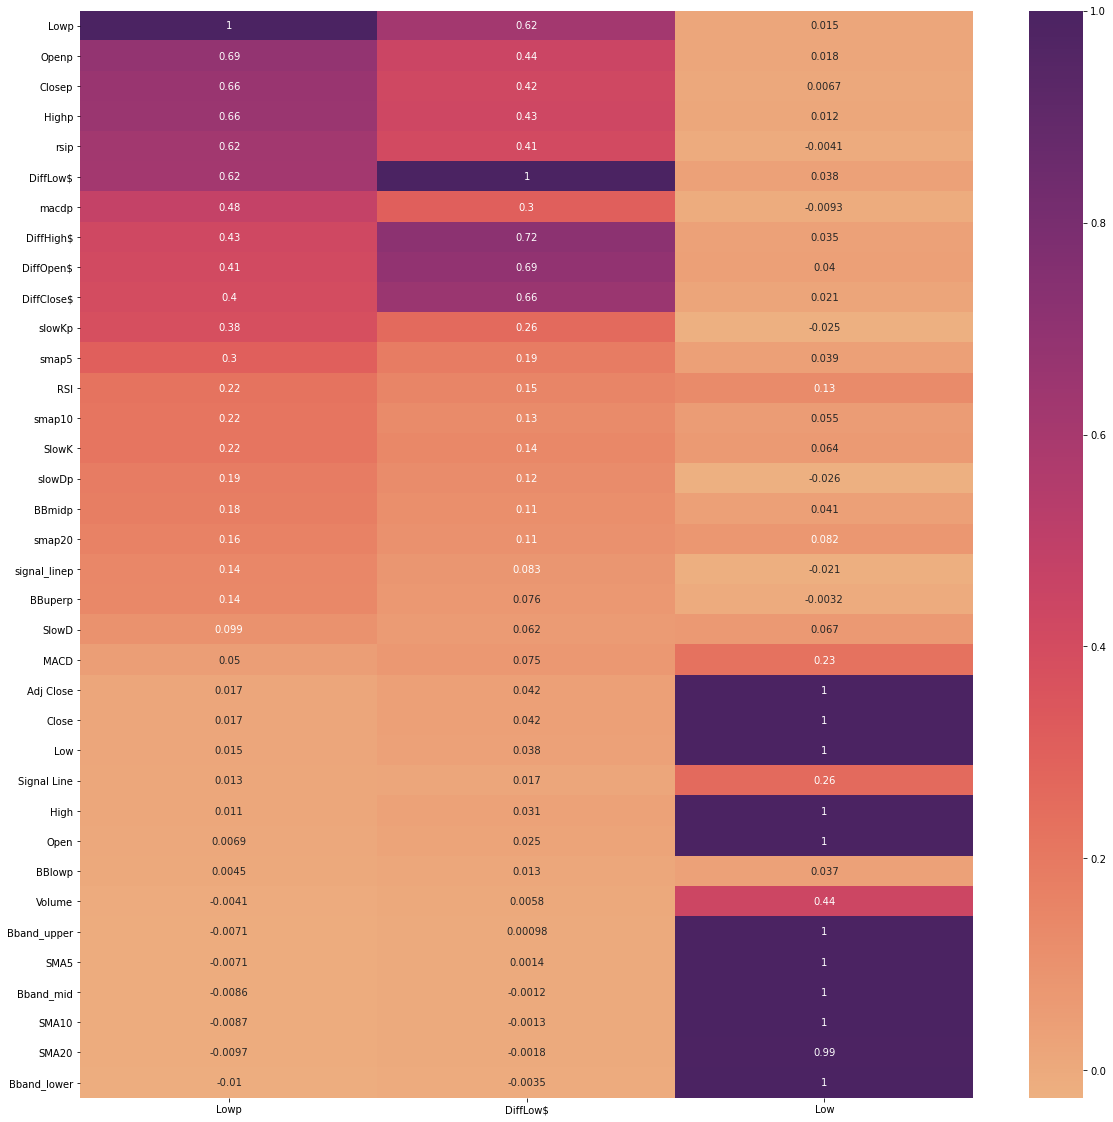

In [94]:
plt.figure(figsize=(20, 20))
heatmap = sns.heatmap(low_corr, annot=True, cmap="flare")

In [95]:
close_top_ten = close_corr.index[:18]
open_top_ten = open_corr.index[:18]
high_top_ten = high_corr.index[:18]
low_top_ten = low_corr.index[:18]

In [151]:
corr["Openp"]

Open            0.017666
High            0.016817
Low             0.017582
Close           0.016943
Adj Close       0.016943
Volume          0.029449
DiffClose$      0.159760
DiffOpen$       0.611516
DiffHigh$       0.418179
DiffLow$        0.444930
Closep          0.268112
Openp           1.000000
Highp           0.645803
Lowp            0.687429
SMA5           -0.003279
SMA10          -0.005805
SMA20          -0.007173
smap5           0.450432
smap10          0.317921
smap20          0.235182
MACD            0.077421
Signal Line     0.019894
macdp           0.703862
signal_linep    0.215142
RSI             0.329357
rsip            0.907790
SlowK           0.250159
SlowD           0.130817
slowKp          0.337434
slowDp          0.224673
Bband_upper    -0.004840
Bband_mid      -0.005488
Bband_lower    -0.006198
BBuperp         0.145230
BBmidp          0.273640
BBlowp          0.075156
Name: Openp, dtype: float64

In [227]:
# Data is based on Open
column = []
value = 0
for col in corr:
    col_name = col
    val = corr["Openp"][col]
    if val >= 0.1 or val <= -0.1:
        column.append(col_name)
        value += val
        print(f"{col_name}: {val}")
print("\n")
print(column)
print("\n")
print(f"Number fo Columns I can use to train: {len(column)}")
print(f"\nTotal corr value: {value}")

DiffClose$: 0.15976048288269729
DiffOpen$: 0.6115158558512528
DiffHigh$: 0.41817923389539335
DiffLow$: 0.4449302823287152
Closep: 0.26811197843396817
Openp: 1.0
Highp: 0.6458034851183253
Lowp: 0.6874292685661203
smap5: 0.450431844046202
smap10: 0.3179205933699724
smap20: 0.23518168114207866
macdp: 0.7038624164196576
signal_linep: 0.21514160636219806
RSI: 0.3293571546015368
rsip: 0.907789909963057
SlowK: 0.25015930515641027
SlowD: 0.13081682498960423
slowKp: 0.33743416314798486
slowDp: 0.22467308384084425
BBuperp: 0.14522988797962916
BBmidp: 0.2736399782758344


['DiffClose$', 'DiffOpen$', 'DiffHigh$', 'DiffLow$', 'Closep', 'Openp', 'Highp', 'Lowp', 'smap5', 'smap10', 'smap20', 'macdp', 'signal_linep', 'RSI', 'rsip', 'SlowK', 'SlowD', 'slowKp', 'slowDp', 'BBuperp', 'BBmidp']


Number fo Columns I can use to train: 21

Total corr value: 8.757369036371484


In [168]:
# Data is based on Open
column = []
value = 0
for col in corr:
    col_name = col
    val = corr["Closep"][col]
    if val >= 0.1:
        column.append(col_name)
        value += val
        print(f"{col_name}: {val}")
print("\n")
print(column)
print("\n")
print(f"Number fo Columns I can use to train: {len(column)}")
print(f"\nTotal corr value: {value}")

DiffClose$: 0.6117528136070767
DiffOpen$: 0.15640307543795215
DiffHigh$: 0.4383156828469084
DiffLow$: 0.4233981747055017
Closep: 1.0
Openp: 0.26811197843396817
Highp: 0.7083177819482294
Lowp: 0.6624285769552862
smap5: 0.12551120206299737
macdp: 0.18810058072657646
rsip: 0.2413641462390137
SlowK: 0.15995592460325925
slowKp: 0.3759527080225567
slowDp: 0.12715037862145126


['DiffClose$', 'DiffOpen$', 'DiffHigh$', 'DiffLow$', 'Closep', 'Openp', 'Highp', 'Lowp', 'smap5', 'macdp', 'rsip', 'SlowK', 'slowKp', 'slowDp']


Number fo Columns I can use to train: 14

Total corr value: 5.486763024210776


In [169]:
# Data is based on Open
column = []
value = 0
for col in corr:
    col_name = col
    val = corr["Highp"][col]
    if val >= 0.1:
        column.append(col_name)
        value += val
        print(f"{col_name}: {val}")
print("\n")
print(column)
print("\n")
print(f"Number fo Columns I can use to train: {len(column)}")
print(f"\nTotal corr value: {value}")

DiffClose$: 0.42002105086296443
DiffOpen$: 0.39231709347912547
DiffHigh$: 0.610841985911899
DiffLow$: 0.4288614123037473
Closep: 0.7083177819482294
Openp: 0.6458034851183253
Highp: 1.0
Lowp: 0.6576351167171065
smap5: 0.297577642002899
smap10: 0.20813775300682247
smap20: 0.16354150063339573
macdp: 0.4570317430461786
signal_linep: 0.14253379231166027
RSI: 0.22417303979693712
rsip: 0.5908996450585262
SlowK: 0.22375997144566837
SlowD: 0.10403784033024772
slowKp: 0.39445341585432636
slowDp: 0.19141140208087348
BBmidp: 0.18171170957493543
BBlowp: 0.11866730632062897


['DiffClose$', 'DiffOpen$', 'DiffHigh$', 'DiffLow$', 'Closep', 'Openp', 'Highp', 'Lowp', 'smap5', 'smap10', 'smap20', 'macdp', 'signal_linep', 'RSI', 'rsip', 'SlowK', 'SlowD', 'slowKp', 'slowDp', 'BBmidp', 'BBlowp']


Number fo Columns I can use to train: 21

Total corr value: 8.161734687804497


In [170]:
# Data is based on Open
column = []
value = 0
for col in corr:
    col_name = col
    val = corr["Lowp"][col]
    if val >= 0.1:
        column.append(col_name)
        value += val
        print(f"{col_name}: {val}")
print("\n")
print(column)
print("\n")
print(f"Number fo Columns I can use to train: {len(column)}")
print(f"\nTotal corr value: {value}")

DiffClose$: 0.4005458250207968
DiffOpen$: 0.4131350345427111
DiffHigh$: 0.42582625931226553
DiffLow$: 0.618561130603677
Closep: 0.6624285769552862
Openp: 0.6874292685661203
Highp: 0.6576351167171065
Lowp: 1.0
smap5: 0.3041490529261532
smap10: 0.21679310482822584
smap20: 0.16403490132160797
macdp: 0.47691037618859883
signal_linep: 0.14464495470302907
RSI: 0.22363340691721093
rsip: 0.6232145150789707
SlowK: 0.21610404109105177
slowKp: 0.37990742301553526
slowDp: 0.18672771992541176
BBuperp: 0.13958215401548565
BBmidp: 0.1816580726894878


['DiffClose$', 'DiffOpen$', 'DiffHigh$', 'DiffLow$', 'Closep', 'Openp', 'Highp', 'Lowp', 'smap5', 'smap10', 'smap20', 'macdp', 'signal_linep', 'RSI', 'rsip', 'SlowK', 'slowKp', 'slowDp', 'BBuperp', 'BBmidp']


Number fo Columns I can use to train: 20

Total corr value: 8.122920934418731


In [72]:
# High
high_orders = pd.DataFrame([close_top_ten, open_top_ten, high_top_ten, low_top_ten]).T
high_orders

,0,1,2,3
0,Closep,Openp,Highp,Lowp
1,Highp,Lowp,rsip,Openp
2,Lowp,Highp,macdp,Closep
3,rsip,macdp,Closep,Highp
4,DiffClose$,DiffOpen$,Lowp,DiffLow$
5,macdp,rsip,Openp,rsip
6,DiffHigh$,DiffLow$,DiffHigh$,macdp
7,DiffLow$,smap5,smap5,DiffHigh$
8,slowKp,DiffHigh$,DiffLow$,DiffOpen$
9,smap5,BBmidp,DiffClose$,DiffClose$


In [58]:
# Low
low_orders = pd.DataFrame([close_top_ten, open_top_ten, high_top_ten, low_top_ten]).T
low_orders

,0,1,2,3
0,Closep,Openp,Highp,Lowp
1,Highp,Lowp,Closep,rsip
2,Lowp,Highp,Lowp,macdp
3,DiffClose$,macdp,Openp,Openp
4,rsip,rsip,rsip,Closep
5,macdp,DiffOpen$,DiffHigh$,Highp
6,DiffHigh$,smap5,macdp,DiffLow$
7,DiffLow$,DiffLow$,DiffLow$,smap5
8,slowKp,DiffHigh$,DiffClose$,DiffHigh$
9,smap5,BBmidp,slowKp,DiffOpen$


In [84]:
# Close
close_order = pd.DataFrame([close_top_ten, open_top_ten, high_top_ten, low_top_ten]).T
close_order

,0,1,2,3
0,Closep,Openp,Highp,Lowp
1,rsip,Lowp,Closep,Openp
2,macdp,Highp,macdp,macdp
3,Highp,DiffOpen$,Lowp,Closep
4,Lowp,macdp,Openp,Highp
5,DiffClose$,DiffLow$,rsip,DiffLow$
6,smap5,smap5,DiffHigh$,rsip
7,DiffHigh$,DiffHigh$,smap5,smap5
8,DiffLow$,BBmidp,DiffLow$,DiffHigh$
9,slowKp,slowKp,DiffClose$,DiffOpen$


In [96]:
# Open
open_order = pd.DataFrame([close_top_ten, open_top_ten, high_top_ten, low_top_ten]).T
open_order

,0,1,2,3
0,Closep,Openp,Highp,Lowp
1,Highp,rsip,Closep,Openp
2,Lowp,macdp,Lowp,Closep
3,DiffClose$,Lowp,Openp,Highp
4,DiffHigh$,Highp,DiffHigh$,rsip
5,DiffLow$,DiffOpen$,rsip,DiffLow$
6,slowKp,smap5,macdp,macdp
7,Openp,DiffLow$,DiffLow$,DiffHigh$
8,rsip,DiffHigh$,DiffClose$,DiffOpen$
9,macdp,slowKp,slowKp,DiffClose$


In [115]:
correration = pd.DataFrame([open_order[1], close_order[0], high_orders[2], low_orders[3]]).T
correration.columns = ["Open", "Close", "High", "Low"]

In [116]:
correration

,Open,Close,High,Low
0,Openp,Closep,Highp,Lowp
1,rsip,rsip,rsip,rsip
2,macdp,macdp,macdp,macdp
3,Lowp,Highp,Closep,Openp
4,Highp,Lowp,Lowp,Closep
5,DiffOpen$,DiffClose$,Openp,Highp
6,smap5,smap5,DiffHigh$,DiffLow$
7,DiffLow$,DiffHigh$,smap5,smap5
8,DiffHigh$,DiffLow$,DiffLow$,DiffHigh$
9,slowKp,slowKp,DiffClose$,DiffOpen$


In [128]:
top_corr_values = np.unique(correration.values)
top_corr_values

array(['BBmidp', 'Closep', 'DiffClose$', 'DiffHigh$', 'DiffLow$',
       'DiffOpen$', 'Highp', 'Lowp', 'Openp', 'RSI', 'SlowK', 'macdp',
       'rsip', 'signal_linep', 'slowDp', 'slowKp', 'smap10', 'smap20',
       'smap5'], dtype=object)

In [133]:
len(top_corr_values)

19

In [15]:
amd.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Closep',
       'Openp', 'Highp', 'Lowp', 'Volp', 'SMA5', 'SMA10', 'SMA20', 'smap5',
       'smap10', 'smap20', 'MACD', 'Signal Line', 'macdp', 'signal_linep',
       'RSI', 'rsip', 'SlowK', 'SlowD', 'slowKp', 'slowDp', 'Bband_upper',
       'Bband_mid', 'Bband_lower', 'BBuperp', 'BBmidp', 'BBlowp'],
      dtype='object')

In [12]:
def split_stationary_nonstationary(df):
    stationary_df = df[["Closep", "Openp", "Highp", "Lowp", "smap5", "smap10", "smap20", "macdp",
                        "signal_linep", "rsip", "slowKp", "slowDp", "BBuperp", "BBmidp", "BBlowp"]]

    non_stationary_df = df[["Open", "High", "Low", "Adj Close", "Volume", "Diff", "SMA5", "SMA10", "SMA20", "MACD",
                            "Signal Line", "RSI", "SlowK", "SlowD", 'Bband_upper', 'Bband_mid', 'Bband_lower']]
    
    return stationary_df, non_stationary_df

In [13]:
st_df, non_st_df = split_stationary_nonstationary(amd)

In [14]:
non_st_df.head()

,Open,High,Low,Adj Close,Volume,Diff,SMA5,SMA10,SMA20,MACD,Signal Line,RSI,SlowK,SlowD,Bband_upper,Bband_mid,Bband_lower
Date,,,,,,,,,,,,,,,,,
1980-04-23,2.562500,2.729167,2.593750,2.614583,588000,0.052083,2.443750,2.507292,2.539063,-0.055092,-0.076269,45.650961,43.750064,27.777863,2.670667,2.415649,2.160630
1980-04-24,2.614583,2.812500,2.614583,2.781250,733200,0.166667,2.514583,2.511458,2.555729,-0.017702,-0.064555,51.963005,73.771390,47.275705,2.843372,2.474770,2.106167
1980-04-25,2.781250,2.760417,2.687500,2.708333,343200,-0.072917,2.591667,2.518750,2.572396,0.000483,-0.051548,49.267134,81.249985,66.257146,2.880292,2.544520,2.208748
1980-04-28,2.708333,2.791667,2.718750,2.729167,372000,0.020834,2.679167,2.535417,2.581771,0.015358,-0.038167,50.064291,86.538469,80.519948,2.769102,2.610221,2.451340
1980-04-29,2.729167,2.729167,2.635417,2.666667,270000,-0.062500,2.700000,2.545833,2.588021,0.018319,-0.026869,47.645654,79.487211,82.425222,2.769500,2.656614,2.543729


In [18]:
st_corr = st_df.corr()
st_corr["Closep"].sort_values(ascending=False)

Closep          1.000000
rsip            0.919035
Openp           0.846109
macdp           0.718466
Lowp            0.607079
Highp           0.595672
slowKp          0.451327
smap5           0.448920
smap10          0.319613
BBmidp          0.279643
signal_linep    0.253076
smap20          0.233825
slowDp          0.169287
BBlowp          0.133864
BBuperp         0.091914
Name: Closep, dtype: float64

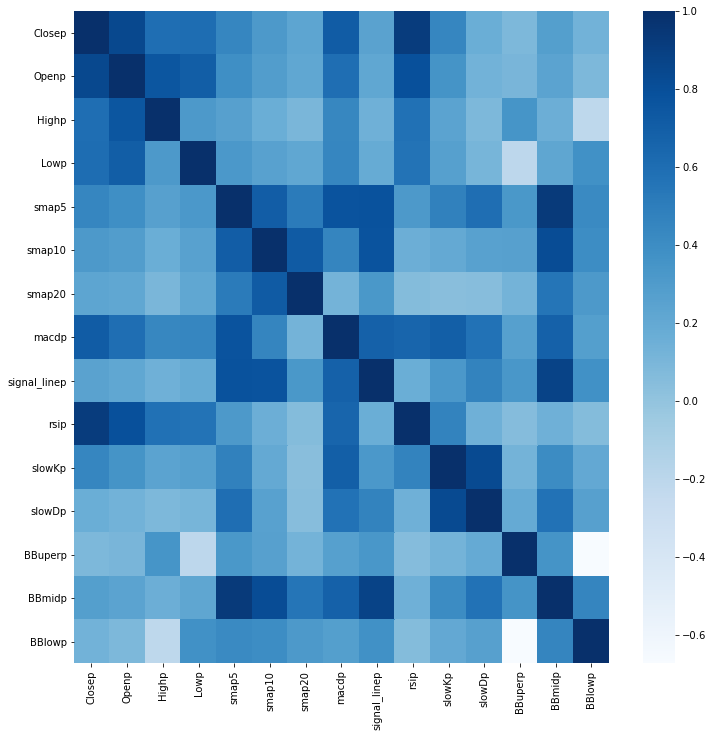

In [19]:
plt.figure(figsize=(12, 12))
st_df_heatmap = sns.heatmap(st_corr, cmap="Blues");

In [20]:
# I don't know this is the raight way to scale yet. 
scaler = StandardScaler()
scaled_st_df = scaler.fit_transform(st_df)

In [21]:
# This is just for check. Don't run it
scaled_st_df_pd = pd.DataFrame(scaled_st_df)
scaled_st_df_pd.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
count,1.058200e+04,1.058200e+04,1.058200e+04,1.058200e+04,1.058200e+04,1.058200e+04,1.058200e+04,1.058200e+04,1.058200e+04,1.058200e+04,1.058200e+04,1.058200e+04,1.058200e+04,1.058200e+04,1.058200e+04
mean,1.018736e-17,4.822997e-17,-1.898248e-16,2.968157e-16,4.646738e-17,-3.134895e-17,-2.648347e-17,1.424762e-17,-1.514990e-17,2.222041e-15,-1.244830e-16,-4.361471e-16,2.343827e-17,-1.817148e-17,3.056471e-17
std,1.000047e+00,1.000047e+00,1.000047e+00,1.000047e+00,1.000047e+00,1.000047e+00,1.000047e+00,1.000047e+00,1.000047e+00,1.000047e+00,1.000047e+00,1.000047e+00,1.000047e+00,1.000047e+00,1.000047e+00
min,-1.269919e+01,-8.740817e+00,-2.558692e+00,-1.695801e+01,-6.653797e+00,-6.373849e+00,-5.310540e+00,-1.003044e+01,-6.412098e+00,-7.446573e+00,-8.974909e+00,-9.047364e+00,-2.007992e+00,-7.093124e+00,-1.084389e+01
25%,-5.035161e-01,-5.557733e-01,-6.416852e-01,-4.141865e-01,-5.454471e-01,-5.567758e-01,-5.721726e-01,-5.665709e-01,-5.946602e-01,-5.993668e-01,-6.772334e-01,-6.881579e-01,-6.623238e-01,-5.580235e-01,-3.472792e-01
50%,-9.239129e-03,9.282404e-04,-2.869716e-01,2.529173e-01,-2.119068e-02,3.005544e-03,-1.457464e-03,-2.703243e-02,-1.104750e-02,-1.431854e-02,-1.477466e-02,-1.183974e-02,-2.202625e-01,-1.257534e-02,2.057365e-01
75%,5.074361e-01,5.133264e-01,3.392505e-01,6.834474e-01,5.619828e-01,5.918085e-01,6.179602e-01,5.538180e-01,5.896780e-01,5.813984e-01,6.702396e-01,6.763380e-01,4.041627e-01,5.719238e-01,6.212081e-01
max,1.118250e+01,8.524695e+00,1.051798e+01,6.070902e+00,6.100878e+00,4.917843e+00,4.251379e+00,7.628717e+00,6.650680e+00,5.858565e+00,4.482977e+00,4.760038e+00,1.028596e+01,5.045021e+00,2.266857e+00


In [22]:
# Just check. Don't run
after_scale = scaled_st_df_pd.corr()[0].sort_values(ascending=False)
before_scale = st_corr["Closep"].sort_values(ascending=False)
pd.DataFrame(columns=[after_scale, before_scale]).T

,
0,Closep
1.000000,1.000000
0.919035,0.919035
0.846109,0.846109
0.718466,0.718466
0.607079,0.607079
0.595672,0.595672
0.451327,0.451327
0.448920,0.448920
0.319613,0.319613


In [23]:
cols = list(scaled_st_df_pd.columns)
scaled_p = []
non_scaled_p = []
for col in cols:
    try:
        p = adfuller(scaled_st_df_pd[col])[1]
        print(col, ":", p)
        scaled_p.append(p)
    except:
        print(col)
        
cols = list(st_df.columns)
for col in cols:
    try:
        p = adfuller(st_df[col])[1]
        print(col, ":", p)
        non_scaled_p.append(p)
    except:
        print(col)

0 : 0.0
1 : 0.0
2 : 2.45095046476835e-17
3 : 5.87944737663168e-17
4 : 2.359240599896174e-28
5 : 9.413782461927209e-29
6 : 3.8153091175145554e-28
7 : 0.0
8 : 0.0
9 : 0.0
10 : 1.5668534668617528e-28
11 : 1.96099197657778e-27
12 : 2.0582128609375e-20
13 : 0.0
14 : 1.0104482670363915e-19
Closep : 0.0
Openp : 0.0
Highp : 2.45095046476459e-17
Lowp : 5.879447376632017e-17
smap5 : 2.3592405998961417e-28
smap10 : 9.413782461927209e-29
smap20 : 3.8153091175149383e-28
macdp : 0.0
signal_linep : 0.0
rsip : 0.0
slowKp : 1.5668534668615398e-28
slowDp : 1.9609919765785246e-27
BBuperp : 2.0582128609376627e-20
BBmidp : 0.0
BBlowp : 1.0104482670364713e-19


In [24]:
np.allclose(scaled_p, non_scaled_p)

True

## Evaluation metrics

* MAE
* RMSE
* MAPE
* sMAPE

## Baseline:

#### ARIMA model for baseline: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

#### sktime: https://www.tensorflow.org/decision_forests

#### Facebook Kats: https://github.com/facebookresearch/Kats

## Create sequential Data

Split the data 

Windowing

In [61]:
# test_window, test_label = get_labelled_windows(x=tf.expand_dims(st_df, axis=0), horizon=30)
# test_window, test_label

In [62]:
# st_df[-30:]

In [25]:
HORIZON = 1
WINDOWS = 5

In [27]:
windows, labels = make_windows(scaled_st_df, window_size=WINDOWS, horizon=HORIZON)
windows.shape, labels.shape

((10577, 5, 15), (10577, 1, 15))

In [28]:
# View first 3 windows/labels
for i in range(3):
    print(f"Window: {windows[i]}\n\nLabels: {labels[i]}\n")

Window: [[ 0.52614683  0.64141955  1.8112827   1.58079722  1.22230169 -0.19414273
  -0.01829105  1.71278802  0.51368518  0.3058931   0.58710087  0.158716
   1.42910749  0.42541649 -1.02654641]
 [ 1.63501886  1.99136317  2.25630097  1.03253098  1.59318388  0.09597085
   0.6958177   2.45676188  1.28907073  1.01836566  1.07180252  0.68616317
   1.98019176  1.42918753 -0.75707076]
 [-0.71613628 -0.80560205 -1.21763203 -0.48289789  1.79821632  0.19759603
   0.7170258   1.20921609  1.46342023 -0.57671514 -0.11433804  0.59199851
   1.87071651  1.69455503 -0.44235806]
 [ 0.1946604   0.24866922  0.38011049  1.20545279  2.04956622  0.49522245
   0.36964913  0.97588712  1.51949195  0.04353472 -0.2212091   0.28215936
   1.66837357  1.59529444 -0.32793434]
 [-0.62566455 -0.70248555 -0.9048261  -0.51181713  0.4510679   0.30219686
   0.23587704  0.19691021  1.28588922 -0.51432912 -0.95005228 -0.49285244
   0.66999056  1.12888687  0.25515013]]

Labels: [[-1.17784618 -1.32641687 -1.55733509 -1.07486392

In [29]:
# Split train and test set
train_windows_full, test_windows, train_labels_full, test_labels = make_train_test_split(windows, labels)

# Split train and validation set
train_windows, val_windows, train_labels, val_labels = make_train_test_split(train_windows_full, train_labels_full, test_split=0.1)
train_windows.shape, val_windows.shape, test_windows.shape, train_labels.shape, val_labels.shape, test_labels.shape

((7614, 5, 15),
 (847, 5, 15),
 (2116, 5, 15),
 (7614, 1, 15),
 (847, 1, 15),
 (2116, 1, 15))

In [66]:
train_price

[array([-1.17784618, -1.32641687, -1.55733509, -1.07486392, -0.30794874,
         0.64277979, -0.45071102, -0.74604901,  0.76192835, -0.89272267,
        -1.09890732, -0.87025482,  0.59974066,  0.33493933, -0.30687651]),
 array([-1.00507646, -1.13258774, -1.07526546, -0.61897686, -1.4839373 ,
         0.07679583, -0.42011654, -1.25453922,  0.16099017, -0.75361218,
        -1.48570188, -1.3549567 , -0.77065103, -0.51926041,  0.32391348]),
 array([ 0.10327164,  0.14124804, -0.72787357,  0.27054592, -1.11894505,
         0.47751907, -0.41856937, -0.77313948, -0.14767489,  0.14289147,
        -1.25069322, -1.47019755, -0.78280153, -0.96444566, -0.01722005]),
 array([ 1.41164653,  1.71488555,  1.38581498,  1.60161511, -0.57685789,
         1.03529958,  0.09893168,  0.52547655,  0.06960803,  1.14123579,
        -0.41584208, -1.20836687,  0.09206085, -0.66777828, -0.61693271]),
 array([ 0.82887241,  1.00439335,  1.09965713,  0.67285832,  0.07104251,
         0.36703612,  0.16368421,  0.988629

### Forcasting at Uber: https://eng.uber.com/forecasting-introduction/

## Creating callbacks

Checkpoint callbacks

EarlyStopping callbacks

In [30]:
import os

save_path = "C:\\Users\\Owner\\OneDrive\\Desktop\\Stock price prediction\\Kaggle challenge"

In [31]:
# EarlyStopping
patience = 30
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=patience)

## Create model

In [58]:
from tensorflow.keras import layers
tf.random.set_seed(42)
np.random.seed(42)

model_1 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Dense(128, kernel_initializer="he_normal", ),
    layers.LeakyReLU(alpha=0.2), 
    layers.Dense(15)
], name="model_1_dense")

model_1.compile(loss="mae", 
               optimizer=tf.keras.optimizers.Nadam(),
               metrics=["mae", "mse"])

history_1 = model_1.fit(train_windows, train_labels, 
                       epochs=100,
                       batch_size=32,
                       validation_data=(val_windows, val_labels),
                       callbacks=[create_model_checkpoint(model_name=model_1.name, save_path=save_path)])

Epoch 1/100
238/238 [==============================] - 2s 4ms/step - loss: 0.8923 - mae: 0.8923 - mse: 1.5045 - val_loss: 0.6904 - val_mae: 0.6902 - val_mse: 0.8640
INFO:tensorflow:Assets written to: C:\Users\Owner\OneDrive\Desktop\Stock price prediction\Kaggle challenge\model_1_dense\assets
Epoch 2/100
238/238 [==============================] - 1s 4ms/step - loss: 0.7598 - mae: 0.7598 - mse: 1.1042 - val_loss: 0.6846 - val_mae: 0.6842 - val_mse: 0.8464
INFO:tensorflow:Assets written to: C:\Users\Owner\OneDrive\Desktop\Stock price prediction\Kaggle challenge\model_1_dense\assets
Epoch 3/100
238/238 [==============================] - 1s 3ms/step - loss: 0.7470 - mae: 0.7470 - mse: 1.0542 - val_loss: 0.6808 - val_mae: 0.6805 - val_mse: 0.8428
INFO:tensorflow:Assets written to: C:\Users\Owner\OneDrive\Desktop\Stock price prediction\Kaggle challenge\model_1_dense\assets
Epoch 4/100
238/238 [==============================] - 1s 4ms/step - loss: 0.7439 - mae: 0.7439 - mse: 1.0551 - val_loss:

238/238 [==============================] - 1s 3ms/step - loss: 0.7375 - mae: 0.7375 - mse: 1.0393 - val_loss: 0.6758 - val_mae: 0.6756 - val_mse: 0.8309
Epoch 94/100
238/238 [==============================] - 1s 3ms/step - loss: 0.7450 - mae: 0.7450 - mse: 1.0589 - val_loss: 0.6764 - val_mae: 0.6762 - val_mse: 0.8329
Epoch 95/100
238/238 [==============================] - 1s 3ms/step - loss: 0.7465 - mae: 0.7465 - mse: 1.0540 - val_loss: 0.6762 - val_mae: 0.6760 - val_mse: 0.8322
Epoch 96/100
238/238 [==============================] - 1s 3ms/step - loss: 0.7446 - mae: 0.7446 - mse: 1.0519 - val_loss: 0.6762 - val_mae: 0.6760 - val_mse: 0.8325
Epoch 97/100
238/238 [==============================] - 1s 3ms/step - loss: 0.7465 - mae: 0.7465 - mse: 1.0938 - val_loss: 0.6756 - val_mae: 0.6755 - val_mse: 0.8314
Epoch 98/100
238/238 [==============================] - 1s 3ms/step - loss: 0.7408 - mae: 0.7408 - mse: 1.0467 - val_loss: 0.6754 - val_mae: 0.6753 - val_mse: 0.8306
Epoch 99/100
238/

In [62]:
model_1 = tf.keras.models.load_model(save_path + "\\" + model_1.name)
model_1.evaluate(val_windows, val_labels)

27/27 [==============================] - 0s 2ms/step - loss: 0.6739 - mae: 0.6738 - mse: 0.8285


[0.6738919019699097, 0.6738407015800476, 0.8284653425216675]

In [49]:
test_windows.shape, test_labels.shape

((2116, 5, 15), (2116, 1, 15))

In [61]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 1, 5, 15)          0         
_________________________________________________________________
dense_8 (Dense)              (None, 1, 5, 128)         2048      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 1, 5, 128)         0         
_________________________________________________________________
dense_9 (Dense)              (None, 1, 5, 15)          1935      
Total params: 3,983
Trainable params: 3,983
Non-trainable params: 0
_________________________________________________________________


In [59]:
model_1_pred = model_1.predict(test_windows, batch_size=15)
model_1_pred.shape

(2116, 1, 5, 15)

In [60]:
model_1_preds = make_preds(model_1, test_windows)
model_1_preds.shape

TensorShape([2116, 5, 15])

In [53]:
model_1_result = evaluate_preds(y_true=test_labels, y_pred=model_1_preds)
model_1_result

InvalidArgumentError: Incompatible shapes: [2116,5] vs. [2116,1,15] [Op:Sub]